In [1]:
# depending on where you run this, this may have to be %matplotlib notebook
%matplotlib inline

import os
import astropy
import requests
import pandas as pd
import numpy as np
import lightkurve as lk 
from scipy.interpolate import interp1d
from astropy.modeling import models, fitting
import matplotlib.pyplot as plt
import emcee
import sys
import csv
from astropy.timeseries import LombScargle
from os.path import basename, exists

# change these paths to wherever you have the files
sys.path.insert(1,'/Users/neisner/Documents/code/utils/')
import filters # Suzanne's functions
import norm

# change these paths to wherever you have the files
sys.path.insert(1,'/Users/neisner/Documents/code/ETV')
import etv_functions # Nora's functions 

%matplotlib inline

In [13]:
from IPython.display import display, HTML, Javascript, clear_output

display(HTML("<style>.container { width:99% !important; }</style>"))  # Jupyter 6
display(HTML("<style>.jp-Notebook { --jp-notebook-max-width: 98%; }</style>"))  # Jupyter 7

etv_functions.enable_info_log_for_jupyter()

# define the paths where the data will be stores - NEED TO CHANGE THIS TO YOUR OWN PATH
outfile_base = './etv_out'  # for ETV
lk_download_dir = 'C:/dev/_juypter/PH_TESS_LightCurveViewer/data'  

# A command from shell that can be run to notify users, e.g., fitting is finished. Use "echo" if you do not have one
NOTIFY_CMD = "win-notify.bat"

if hasattr(lk, "conf"):  # default download dir
    lk.conf.cache_dir = lk_download_dir
if hasattr(lk.search, "sr_cache"):   # PR for persistent query result cache
    lk.search.sr_cache.cache_dir = lk_download_dir  # None
    lk.search.sr_cache.expire_second = 86400

In [3]:
# define the plotting parameters

figsize = (8,4)

In [4]:
# import the data

# choose a TIC ID to analyze
ticid =  272650576

# define the paths where the data will be stores - NEED TO CHANGE THIS TO YOUR OWN PATH
outfile_path = f"{outfile_base}/tic{ticid}_etv_primary.csv"
outfile_path_s = f"{outfile_base}/tic{ticid}_etv_secondary.csv"


# import data using Lightkurve
sr = lk.search_lightcurve('TIC {}'.format(ticid), author = 'SPOC')
display(sr)
search_result = sr.download_all().stitch()

time = search_result.time.value
flux = search_result.flux.value
fluxerr = search_result.flux_err.value

#,mission,year,author,exptime,target_name,distance,proposal_id
,,,,s,,arcsec,
0,TESS Sector 14,2019,SPOC,120,272650576,0.0,G022062
1,TESS Sector 15,2019,SPOC,120,272650576,0.0,G022062
2,TESS Sector 16,2019,SPOC,120,272650576,0.0,G022062
3,TESS Sector 20,2019,SPOC,120,272650576,0.0,G022062
4,TESS Sector 21,2020,SPOC,120,272650576,0.0,G022062
5,TESS Sector 22,2020,SPOC,120,272650576,0.0,G022062
6,TESS Sector 23,2020,SPOC,120,272650576,0.0,G022062
7,TESS Sector 26,2020,SPOC,120,272650576,0.0,G022062
8,TESS Sector 40,2021,SPOC,120,272650576,0.0,G04171


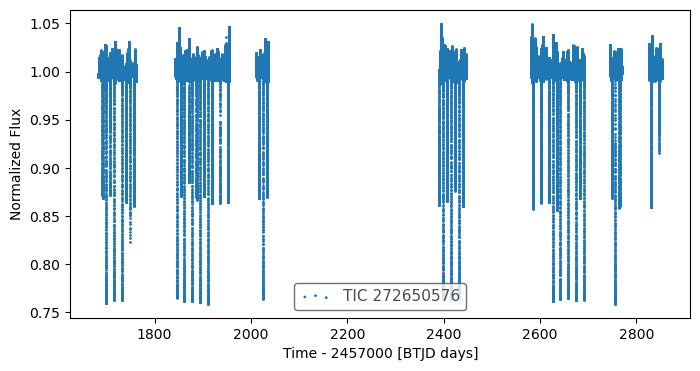

In [16]:
# mask out data you don't like...

fig, ax = plt.subplots(figsize=figsize)
search_result.scatter(ax = ax)

mask = time < 0  # (time > 2893.16-1) & (time < 2893.16+1) 

time = time[~mask]
flux = flux[~mask]
fluxerr = fluxerr[~mask]

# make sure that therte are no nans!

finite_mask = np.isfinite(time) * np.isfinite(flux) * np.isfinite(fluxerr)

# make a dictionary of the data 

data = pd.DataFrame({'time': time[finite_mask], 'flux': flux[finite_mask], 'err': fluxerr[finite_mask]})


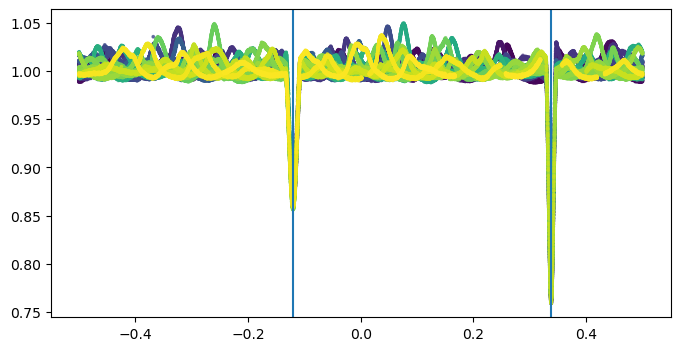

In [17]:
# define the orbital period and the t0 


# epoch=1699.2054, duration_hr=6.8891, period=16.256833, label="s0014-s0060:TCE1",
# epoch=1691.7634, duration_hr=9.8889, period=16.256819, label="s0014-s0060:TCE2",

period = 16.256833  # TCE1
period = 16.256853  # MCMC fit on df_primary: 16.256853268128694

t0_primary = 1699.2054
t0_secondary = 1691.7634

# t0_for_plotting = 0  # keep 0 for plotting purposes
t0_for_plotting = 3  # use a custom one so that the eclipses are not near the edge (-0.5 or +0.5), nearing the edge seems to break some of the subsequent codes 

phase = etv_functions.phase_data(data['time'], t0_for_plotting, period)

fig, ax = plt.subplots(figsize = (8,4))

plt.scatter(phase,data['flux'], s = 3, alpha = 0.7, c = data['time'])

# add the phase to the dataframe
data['phase'] = phase

plt.axvline(etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0])
plt.axvline(etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0])
plt.show();

### Now that the data is ready we can start 

In [18]:
data

,time,flux,err,phase
0,1683.352714,0.996105,0.000599,0.362730
1,1683.354103,0.994851,0.000598,0.362816
2,1683.355492,0.994527,0.000598,0.362901
3,1683.356880,0.996027,0.000598,0.362987
4,1683.358269,0.994235,0.000598,0.363072
...,...,...,...,...
263961,2853.131534,1.010973,0.000541,0.318774
263962,2853.132923,1.011882,0.000541,0.318859
263963,2853.134312,1.012334,0.000541,0.318945
263964,2853.135700,1.011716,0.000541,0.319030


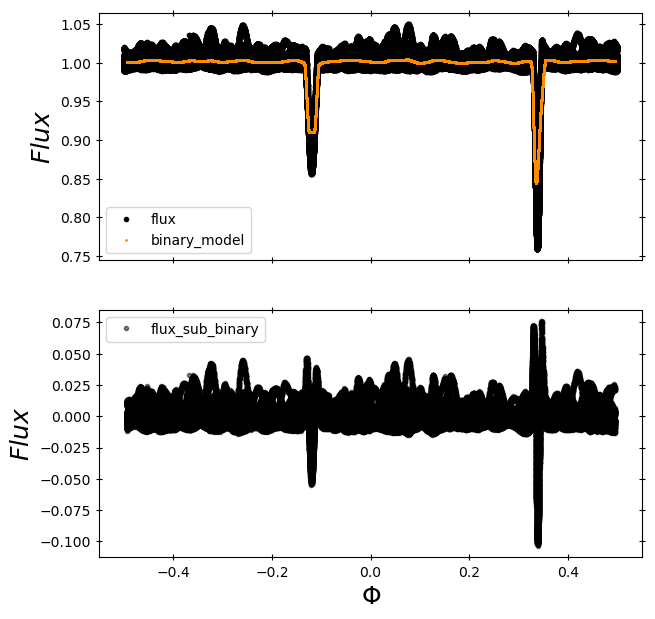

,time,flux,err,phase,flux_sub_binary,binary_model
0,1683.352714,0.996105,0.000599,0.362730,-0.007482,1.003587
1,1683.354103,0.994851,0.000598,0.362816,-0.008734,1.003585
2,1683.355492,0.994527,0.000598,0.362901,-0.009057,1.003584
3,1683.356880,0.996027,0.000598,0.362987,-0.007555,1.003583
4,1683.358269,0.994235,0.000598,0.363072,-0.009347,1.003581
...,...,...,...,...,...,...
263961,2853.131534,1.010973,0.000541,0.318774,0.008713,1.002260
263962,2853.132923,1.011882,0.000541,0.318859,0.009631,1.002251
263963,2853.134312,1.012334,0.000541,0.318945,0.010091,1.002242
263964,2853.135700,1.011716,0.000541,0.319030,0.009483,1.002233


In [19]:
# phase fold the data and create an appoximate binary model (top) and subtract it from the data (bottom)
#_, _ , flux_sub_binary, model, _, _ = etv_functions.trend_removal_interact(period, 0, data['time'], data['flux'], data['time'], data['flux'])

data = etv_functions.trend_removal_interact(period, t0_for_plotting, data)
data

10 261488 901
reached the end
10 234203 901
reached the end
10 223646 901
reached the end
10 217978 901
reached the end
10 214844 901
reached the end


,time,flux,err,phase,flux_sub_binary,binary_model,flux_detrended
0,1683.352714,0.996105,0.000599,0.362730,-0.007482,1.003587,1.004638
1,1683.354103,0.994851,0.000598,0.362816,-0.008734,1.003585,1.003348
2,1683.355492,0.994527,0.000598,0.362901,-0.009057,1.003584,1.002986
3,1683.356880,0.996027,0.000598,0.362987,-0.007555,1.003583,1.004450
4,1683.358269,0.994235,0.000598,0.363072,-0.009347,1.003581,1.002622
...,...,...,...,...,...,...,...
263961,2853.131534,1.010973,0.000541,0.318774,0.008713,1.002260,1.001767
263962,2853.132923,1.011882,0.000541,0.318859,0.009631,1.002251,1.002625
263963,2853.134312,1.012334,0.000541,0.318945,0.010091,1.002242,1.003019
263964,2853.135700,1.011716,0.000541,0.319030,0.009483,1.002233,1.002345


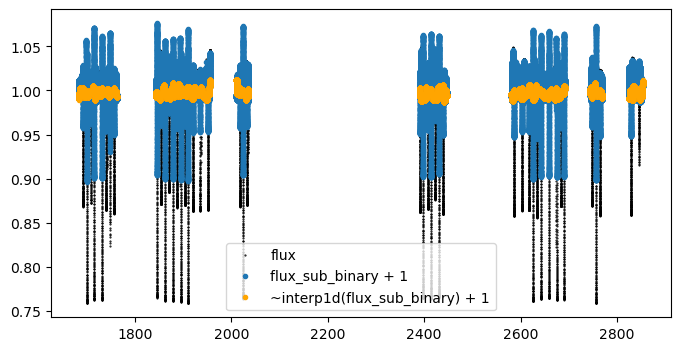

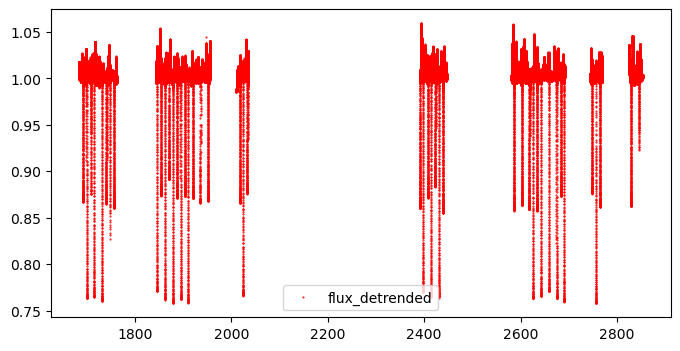

In [20]:
# if you want to detrend the data run this line!

data = etv_functions.detrend_suz(data, T_dur = 10, plot = True)
data

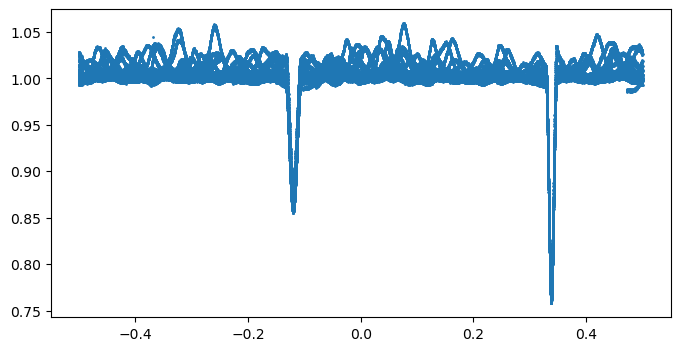

In [21]:
# plot the phase folded data here so that you know at what phase you want to cut the data to model 
fig, ax = plt.subplots(figsize = figsize)
plt.scatter(data.phase, data.flux_detrended, s = 1)
plt.show()

Primary:   1699.2054 0.3378690820419037
Secondary: 1691.7634 -0.11990709394984622


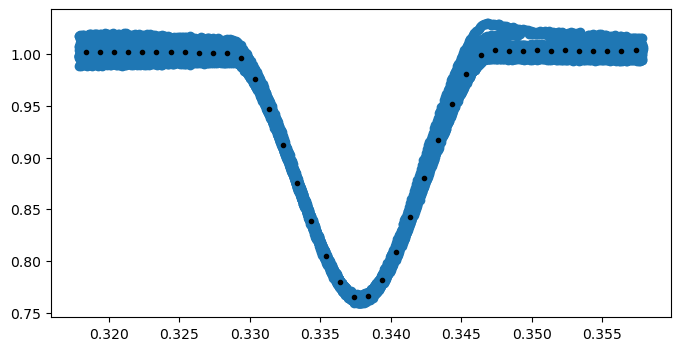

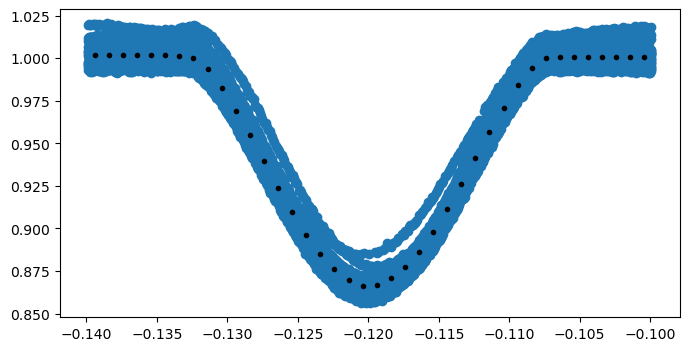

In [22]:
# define the midpoints of the primary and secondary eclipses and the window width

# if these don't look central - change them!! the eclipses should be central
midpoint_p =  etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0]  # convet to time in phase
midpoint_s =  etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0]

print('Primary:  ', t0_primary, midpoint_p)
print('Secondary:', t0_secondary, midpoint_s)

# change depending on the width of the eclipses
window_width = 0.02


data_primary = data[(data['phase'] > midpoint_p - window_width) & (data['phase'] < midpoint_p + window_width) ]
data_secondary = data[(data['phase'] > midpoint_s - window_width) & (data['phase'] < midpoint_s + window_width) ]

ph_binned,flux_binned,err_binned = etv_functions.run_binning_phased(data_primary.phase, data_primary.flux, yerr=data_primary.err,nbins=1000)
ph_binned_s,flux_binned_s,err_binned_s = etv_functions.run_binning_phased(data_secondary.phase, data_secondary.flux, yerr=data_secondary.err,nbins=1000)


# -- -- -- -- -- -- -- -- -- 

fig = plt.subplots(figsize=figsize, sharex=True)
plt.errorbar(ph_binned, flux_binned, yerr=err_binned, fmt=".k", capsize=0, zorder = 2)
plt.scatter(data_primary.phase, data_primary.flux, zorder = -2)
plt.show()

# -- -- -- -- -- -- -- -- -- 
fig = plt.subplots(figsize=figsize, sharex=True)
plt.errorbar(ph_binned_s, flux_binned_s, yerr=err_binned_s, fmt=".k", capsize=0, zorder = 2)
plt.scatter(data_secondary.phase, data_secondary.flux, zorder = -2)
plt.show() 

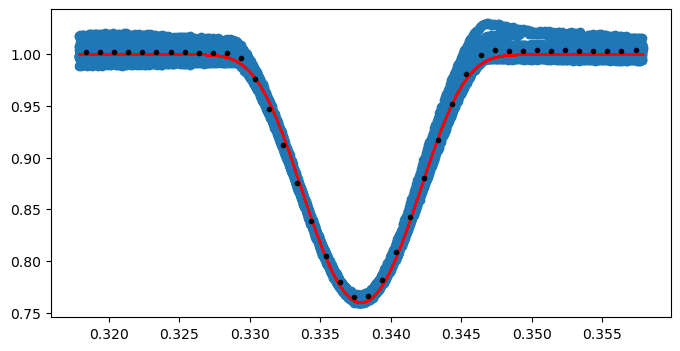

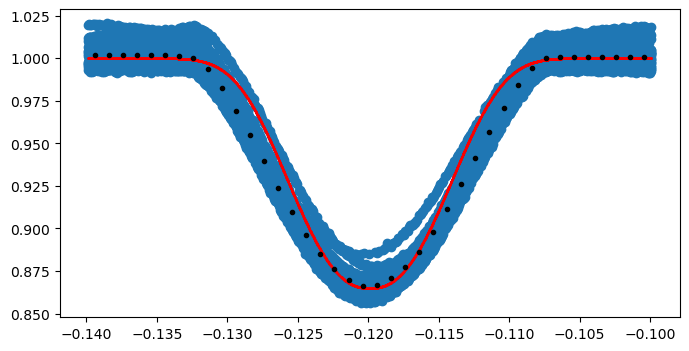

In [23]:

# you need initial guesses!! The order is :
# alpha0, alpha1, t0, d, Tau - CHANGE THESE TO YOUR OWN INITIAL GUESSES
# median flux, -eclipse depth, t0, related to duration, related to shape (U or V) 
# t0 in normalixed phase
start_vals = [1, -0.24, midpoint_p, 0.004, 1.0]
start_vals_s = [1, -0.135, midpoint_s, 0.005, 1.2]

# - - -- - 

etv_functions.plot_initial_guess(data_primary, ph_binned, flux_binned, err_binned, *start_vals)
etv_functions.plot_initial_guess(data_secondary, ph_binned_s, flux_binned_s, err_binned_s, *start_vals_s)


emcee parallel enabled, use 11 CPUs.


100%|██████████████████████████████████████████████████████████| 1000/1000 [03:10<00:00,  5.24it/s]


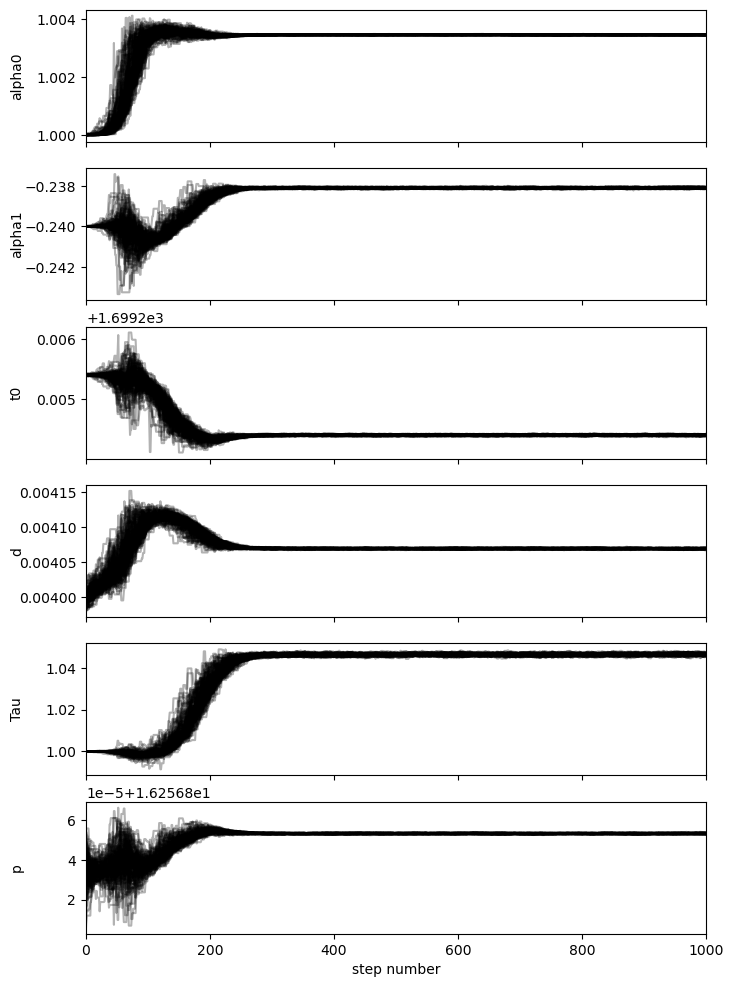

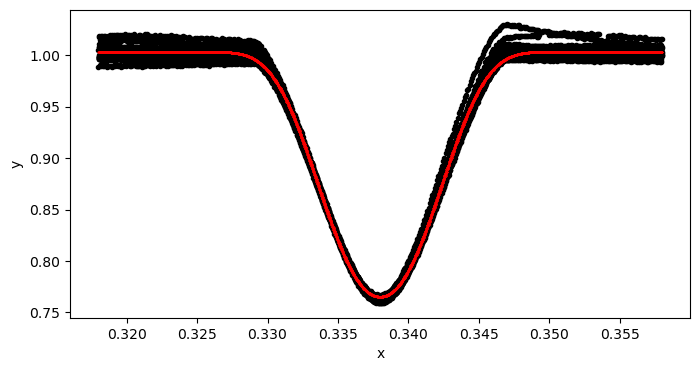

mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau, mean_p = 1.0034506961313099, -0.23810329901751986, 1699.2043940128028, 0.004069450805890426, 1.0464238415557103, 16.256853268128694
std_p: 2.0895676473398213e-07


In [15]:
# use MCMC to refine the period

use_mcmc_to_fit_period = False


if use_mcmc_to_fit_period:
    import etv_functions_with_period as etvp
    # reload(etvp)
        
    # MCMC result
    # mean_alpha0, mean_alpha1, mean_t0_time, mean_d, mean_Tau, mean_p = 1.0034506961313099, -0.23810329901751986, 1699.2043940128028, 0.004069450805890426, 1.0464238415557103, 16.256853268128694
    # std_p: 2.0895676473398213e-07
    mean_alpha0, mean_alpha1, mean_t0_time, mean_d, mean_Tau, mean_p, fit_params_p_stats = etvp.run_mcmc_initial_fit_p(
        data_primary[:],
        [1, -0.24, t0_primary, 0.004, 1.0, period],
        nruns=1000, discard=600, 
        # nruns=20, discard=1, 
        pool=-1,
        plot_chains=True,
        plot=True,
        also_return_stats=True,
    )
    print("mean_alpha0, mean_alpha1, mean_t0_time, mean_d, mean_Tau, mean_p = " + ", ".join([str(v) for v in [mean_alpha0, mean_alpha1, mean_t0_time, mean_d, mean_Tau, mean_p]]))
    print("std_p:", fit_params_p_stats["std_p"])

emcee parallel enabled, use 11 CPUs.


100%|██████████████████████████████████████████████████████████| 1000/1000 [01:20<00:00, 12.47it/s]


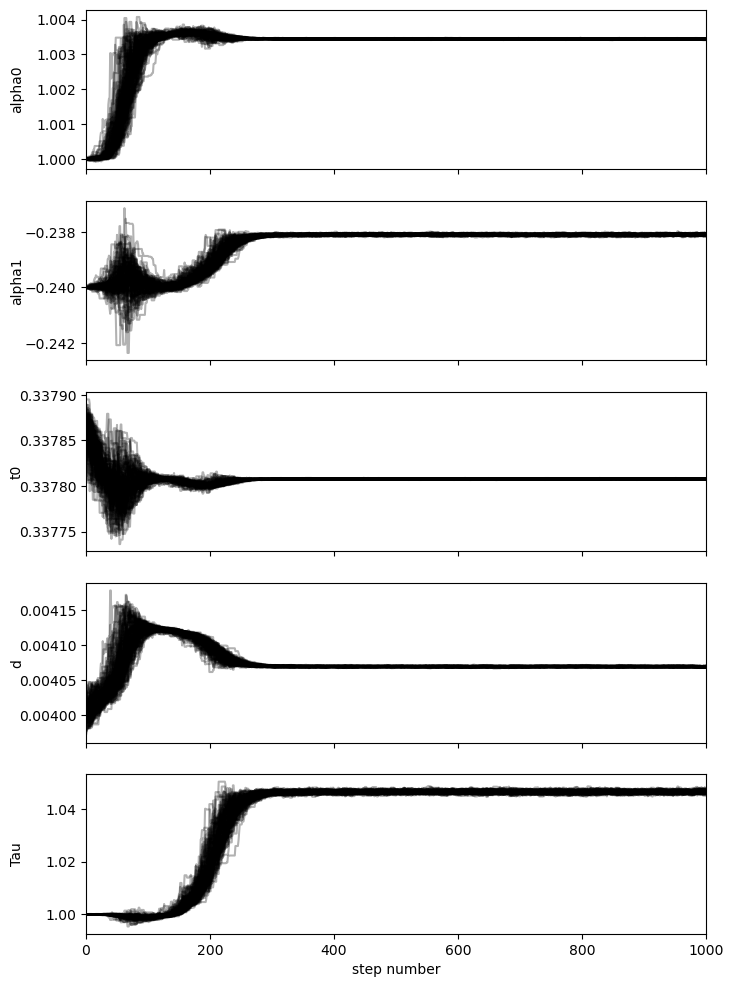

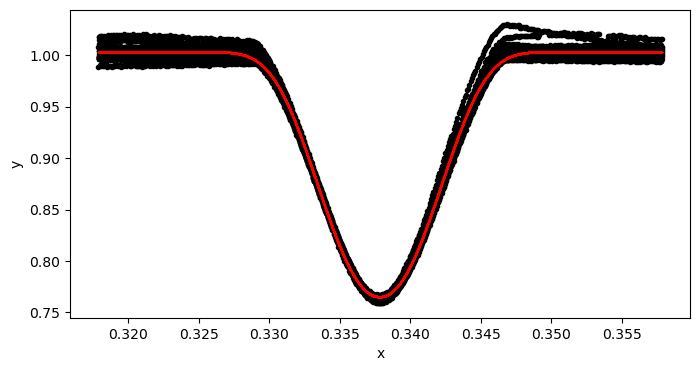

emcee parallel enabled, use 11 CPUs.


100%|██████████████████████████████████████████████████████████| 1000/1000 [01:36<00:00, 10.32it/s]


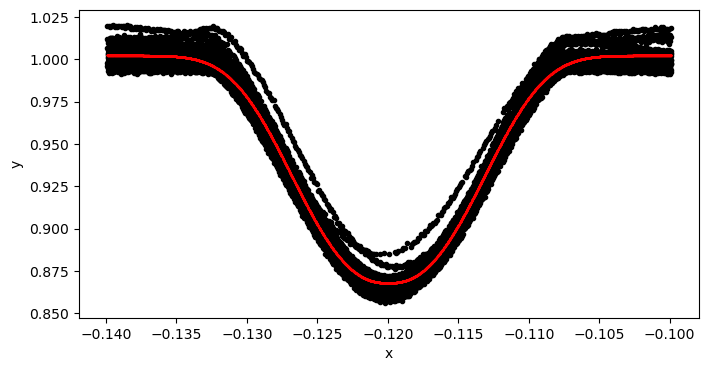

In [32]:
# run the initial model fit using MCMC for the primary and secondary eclipses 
from importlib import reload
reload(etv_functions)

mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau = etv_functions.run_mcmc_initial_fit(data_primary, start_vals, 
                                                                                         nruns=1000, discard=600, 
                                                                                         # nruns=20, discard=1, 
                                                                                         pool=-1, plot_chains = True, plot = True)
mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s = etv_functions.run_mcmc_initial_fit(data_secondary, start_vals_s, nruns = 1000, pool=-1, plot_chains = False, plot = True)
!$NOTIFY_CMD "Initial fit done"

In [ ]:
# Initial model params, based on MCMC period
# mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau = 1.0034439231534114, -0.23809590137500114, 0.33780774253804846, 0.0040692258847070065, 1.0465030588708875
# mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s = 1.0022908037652092, -0.13443899934688142, -0.11998450484782985, 0.005844973277963229, 1.2068833134048695


In [33]:
print("Initial model params:")  # For information, and they can be copied to the cell above for future reuse

print("mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau = " + ", ".join([str(v) for v in [mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau]]))
if t0_secondary is not None:
    print("mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s = " + ", ".join([str(v) for v in [mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s]]))

Initial model params:
mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau = 1.0034439231534114, -0.23809590137500114, 0.33780774253804846, 0.0040692258847070065, 1.0465030588708875
mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s = 1.0022908037652092, -0.13443899934688142, -0.11998450484782985, 0.005844973277963229, 1.2068833134048695


71

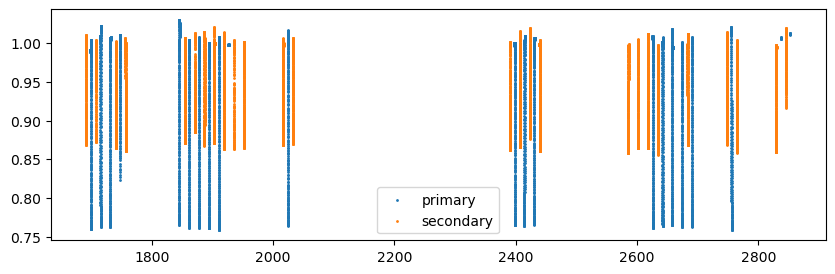

In [34]:
fig = plt.subplots(figsize=(10, 3), sharex=True)
plt.scatter(data_primary.time,data_primary.flux , s = 1, label = 'primary')
plt.scatter(data_secondary.time,data_secondary.flux , s = 1, label = 'secondary')
plt.legend()

# calculate the number of transits there are within the data 
n_transits = int((max(data_primary.time) - min(data_primary.time)) / period)
n_transits

1699.2054 16.256853 1699.2054


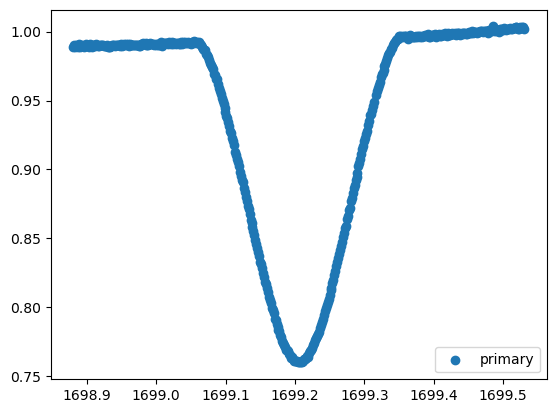

1699.2054 16.256853 1715.4622530000001


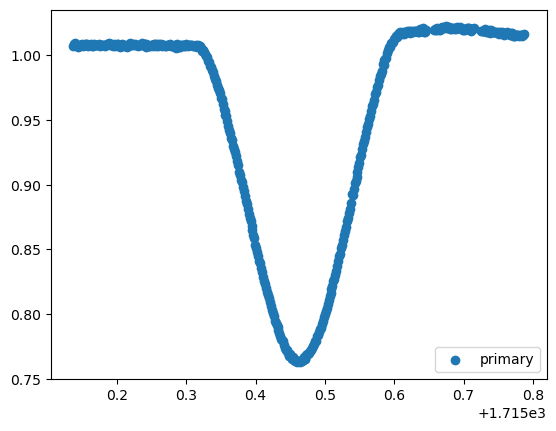

1699.2054 16.256853 1731.719106


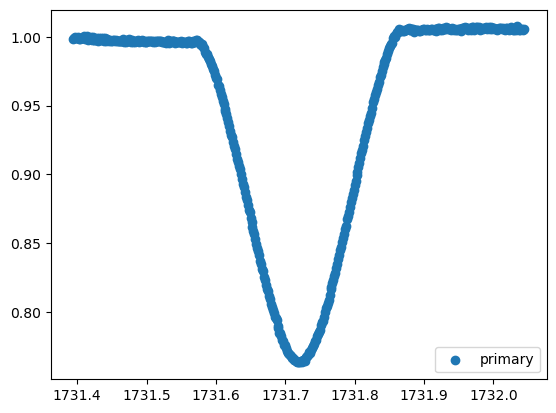

1691.7634 16.256853 1691.7634


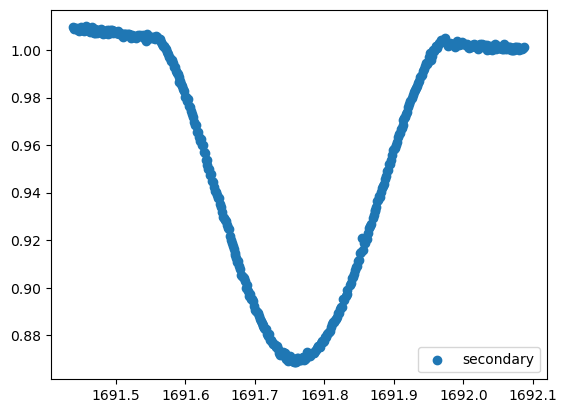

1691.7634 16.256853 1708.0202530000001


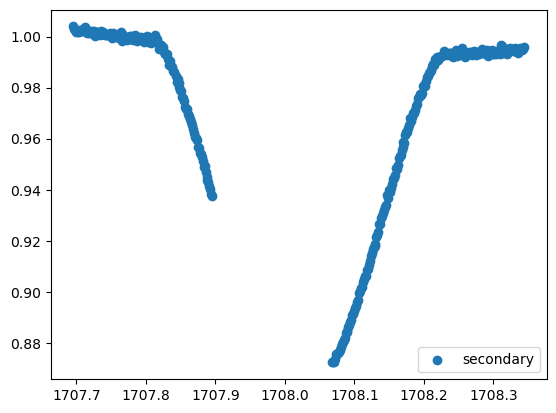

1691.7634 16.256853 1724.277106


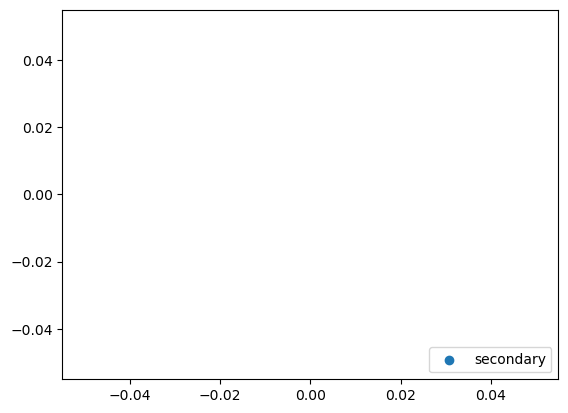

In [35]:
tr_index = range(0,n_transits)

for i in tr_index[0:3]:        
    transit_time = t0_primary+(period*i)
    x = np.array(data_primary.time)
    y = np.array(data_primary.flux) 
    yerr = np.array(data_primary.err)
    
    print (t0_primary, period, transit_time)
    
    mask = (x > (transit_time - (0.2*period))) & (x < (transit_time + (0.2*period))) 
    
    x = np.array(x[mask])
    y = np.array(y[mask]) 
    yerr = np.array(yerr[mask])
    fig, ax = plt.subplots()
    plt.scatter(x,y, label="primary")
    plt.legend(loc="lower right")
    plt.show()
    

for i in tr_index[0:3]:        
    transit_time = t0_secondary+(period*i)
    x = np.array(data_secondary.time)
    y = np.array(data_secondary.flux) 
    yerr = np.array(data_secondary.err)
    
    print (t0_secondary, period, transit_time)
    
    mask = (x > (transit_time - (0.2*period))) & (x < (transit_time + (0.2*period))) 
    
    x = np.array(x[mask])
    y = np.array(y[mask]) 
    yerr = np.array(yerr[mask])
    fig, ax = plt.subplots()
    plt.scatter(x,y, label="secondary")
    plt.legend(loc="lower right")
    plt.show()

Fitting individual primary eclipses...
Existing manifest file found, will skip previously processed LCs and append to end of manifest file
Number 0 has already been completed -- skip
Number 1 has already been completed -- skip
Number 2 has already been completed -- skip
Number 3 has already been completed -- skip
Number 9 has already been completed -- skip
Number 10 has already been completed -- skip
Number 11 has already been completed -- skip
Number 12 has already been completed -- skip
Number 13 has already been completed -- skip
Time 1926.801342 does not have enough data points: 13
Number 20 has already been completed -- skip
Number 43 has already been completed -- skip
Number 44 has already been completed -- skip
Number 45 has already been completed -- skip
Number 57 has already been completed -- skip
Number 58 has already been completed -- skip
Number 59 has already been completed -- skip
Number 60 has already been completed -- skip
Number 61 has already been completed -- skip
Nu

100%|███████████████████████████████████████████████████████| 10000/10000 [00:35<00:00, 278.89it/s]


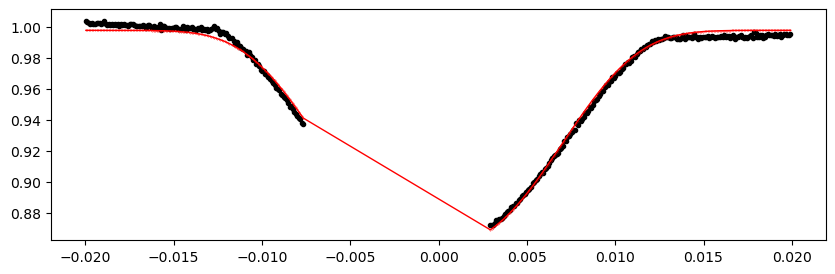

1740.533959 1.0022908037652092 -0.13443899934688142 -0.11998450484782985


100%|███████████████████████████████████████████████████████| 10000/10000 [00:39<00:00, 250.64it/s]


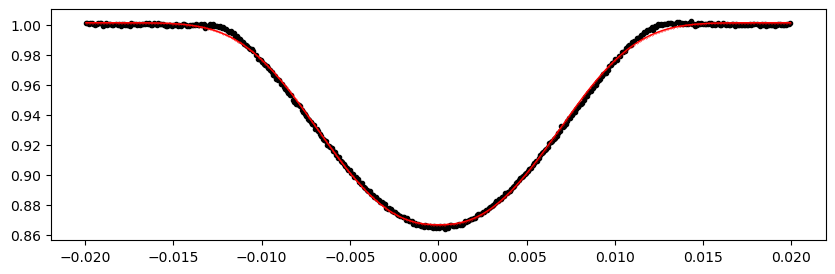

1756.790812 1.0022908037652092 -0.13443899934688142 -0.11998450484782985


100%|███████████████████████████████████████████████████████| 10000/10000 [00:40<00:00, 247.11it/s]


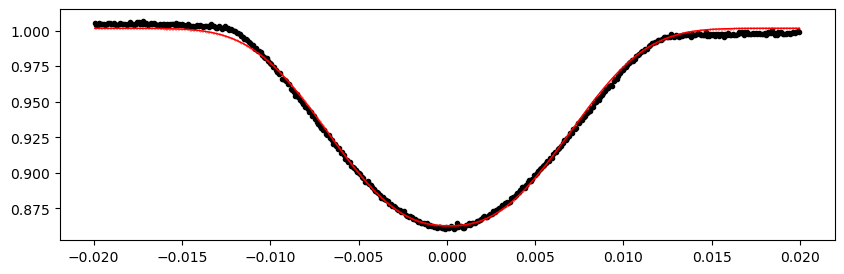

1854.33193 1.0022908037652092 -0.13443899934688142 -0.11998450484782985


100%|███████████████████████████████████████████████████████| 10000/10000 [00:40<00:00, 249.61it/s]


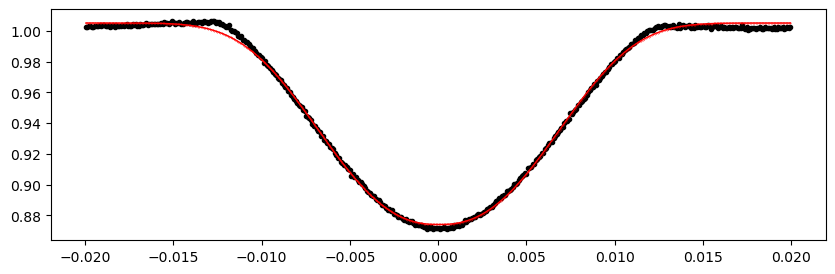

1870.5887830000001 1.0022908037652092 -0.13443899934688142 -0.11998450484782985


100%|███████████████████████████████████████████████████████| 10000/10000 [00:33<00:00, 296.05it/s]


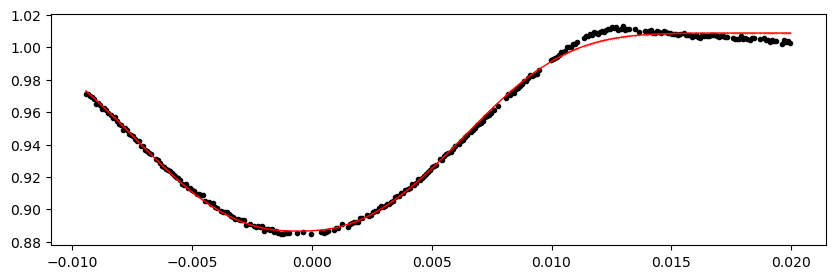

1886.845636 1.0022908037652092 -0.13443899934688142 -0.11998450484782985


100%|███████████████████████████████████████████████████████| 10000/10000 [00:39<00:00, 250.57it/s]


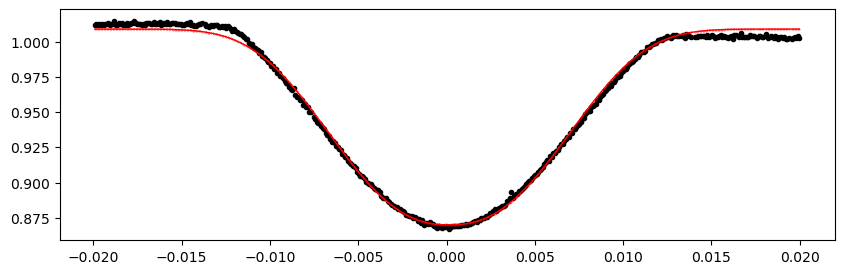

1903.102489 1.0022908037652092 -0.13443899934688142 -0.11998450484782985


100%|███████████████████████████████████████████████████████| 10000/10000 [00:40<00:00, 249.25it/s]


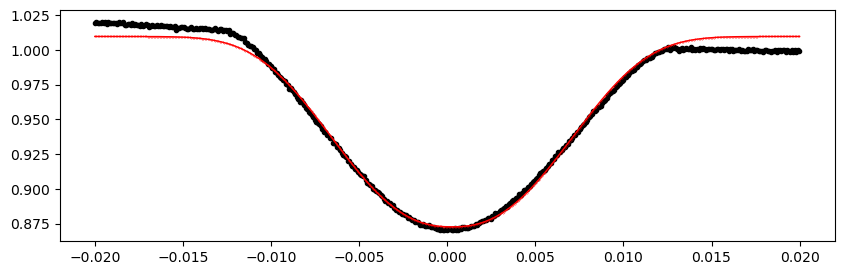

1919.359342 1.0022908037652092 -0.13443899934688142 -0.11998450484782985


100%|███████████████████████████████████████████████████████| 10000/10000 [00:40<00:00, 249.41it/s]


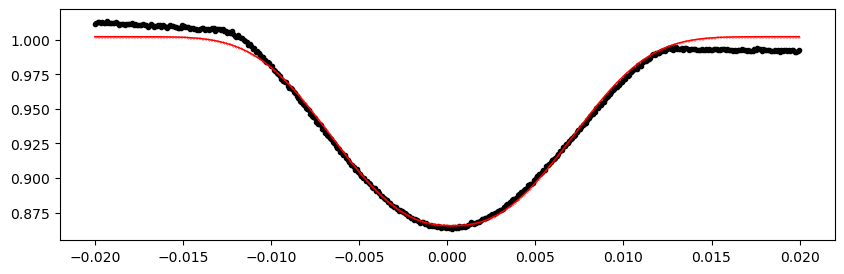

1935.616195 1.0022908037652092 -0.13443899934688142 -0.11998450484782985


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 317.75it/s]


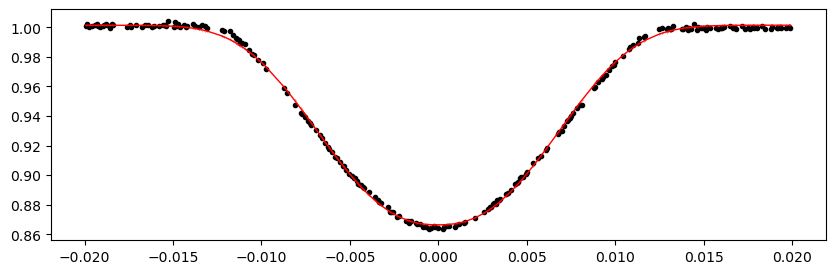

1951.873048 1.0022908037652092 -0.13443899934688142 -0.11998450484782985


100%|███████████████████████████████████████████████████████| 10000/10000 [00:39<00:00, 252.32it/s]


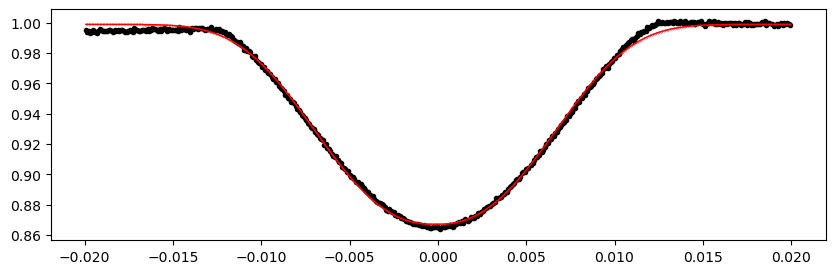

2016.90046 1.0022908037652092 -0.13443899934688142 -0.11998450484782985


100%|███████████████████████████████████████████████████████| 10000/10000 [00:39<00:00, 250.00it/s]


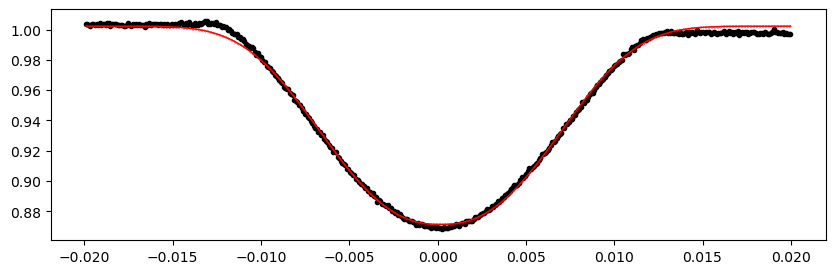

2033.1573130000002 1.0022908037652092 -0.13443899934688142 -0.11998450484782985


100%|███████████████████████████████████████████████████████| 10000/10000 [00:42<00:00, 237.53it/s]


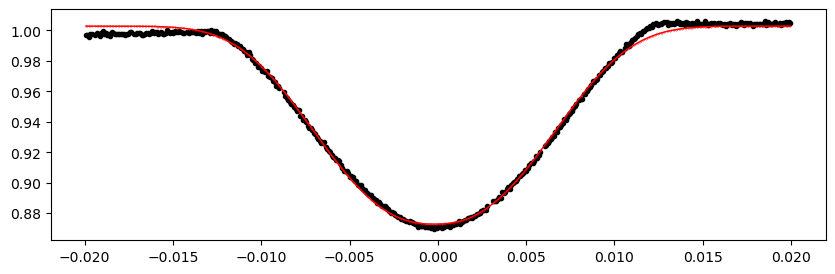

2390.808079 1.0022908037652092 -0.13443899934688142 -0.11998450484782985


100%|███████████████████████████████████████████████████████| 10000/10000 [00:35<00:00, 278.28it/s]


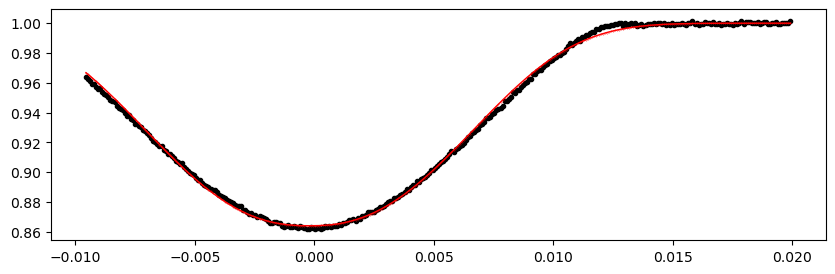

2407.064932 1.0022908037652092 -0.13443899934688142 -0.11998450484782985


100%|███████████████████████████████████████████████████████| 10000/10000 [00:39<00:00, 251.47it/s]


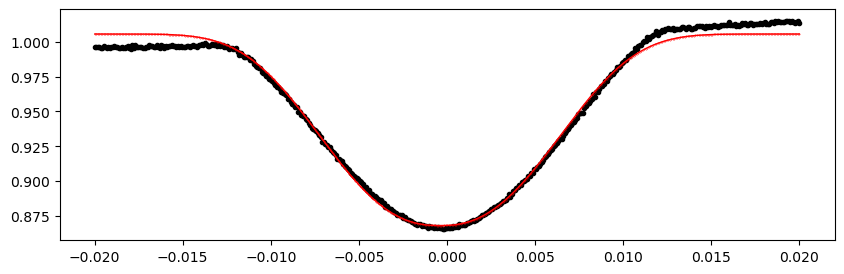

2423.321785 1.0022908037652092 -0.13443899934688142 -0.11998450484782985


100%|███████████████████████████████████████████████████████| 10000/10000 [00:39<00:00, 250.09it/s]


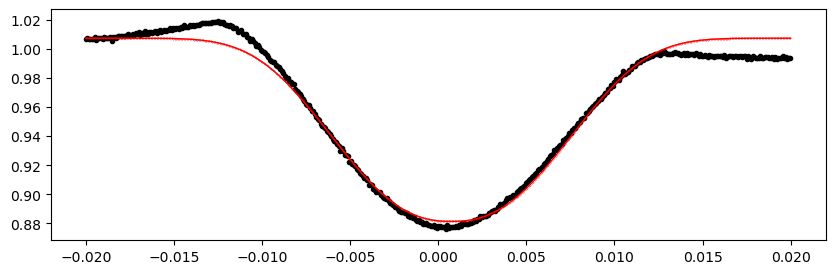

2439.578638 1.0022908037652092 -0.13443899934688142 -0.11998450484782985


100%|███████████████████████████████████████████████████████| 10000/10000 [00:39<00:00, 251.07it/s]


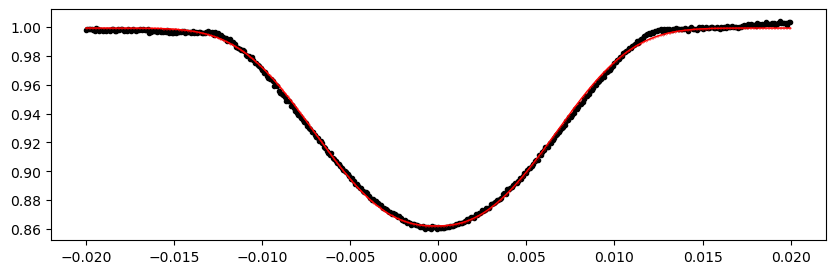

2585.890315 1.0022908037652092 -0.13443899934688142 -0.11998450484782985


100%|███████████████████████████████████████████████████████| 10000/10000 [00:39<00:00, 250.96it/s]


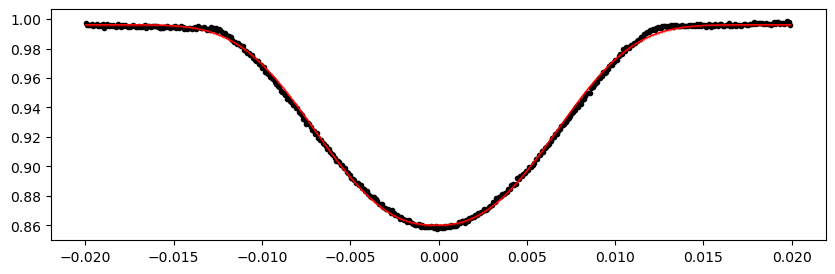

2602.147168 1.0022908037652092 -0.13443899934688142 -0.11998450484782985


100%|███████████████████████████████████████████████████████| 10000/10000 [00:40<00:00, 247.17it/s]


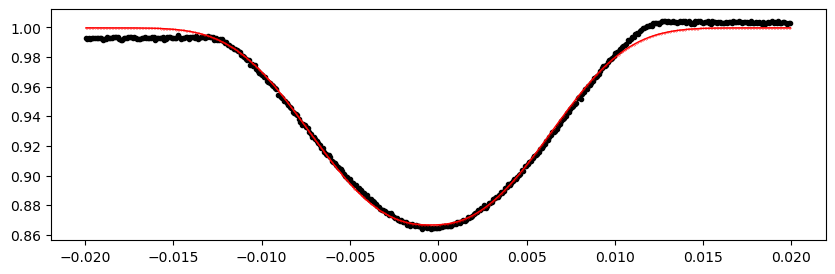

2618.4040210000003 1.0022908037652092 -0.13443899934688142 -0.11998450484782985


100%|███████████████████████████████████████████████████████| 10000/10000 [00:42<00:00, 233.70it/s]


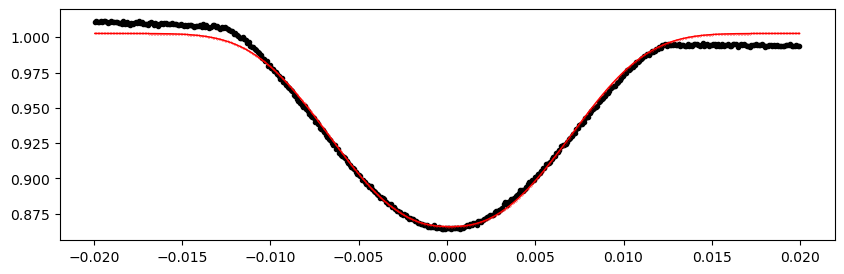

2634.660874 1.0022908037652092 -0.13443899934688142 -0.11998450484782985


100%|███████████████████████████████████████████████████████| 10000/10000 [00:39<00:00, 252.95it/s]


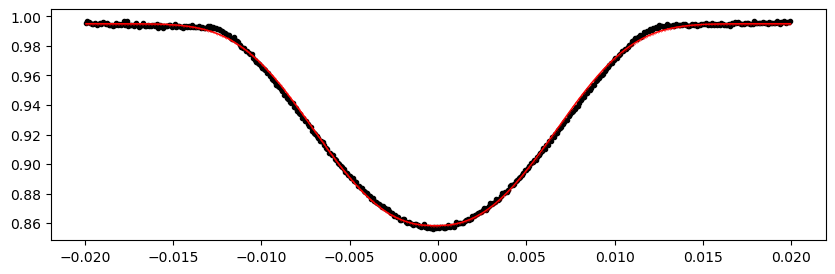

2683.4314329999997 1.0022908037652092 -0.13443899934688142 -0.11998450484782985


100%|███████████████████████████████████████████████████████| 10000/10000 [00:40<00:00, 244.84it/s]


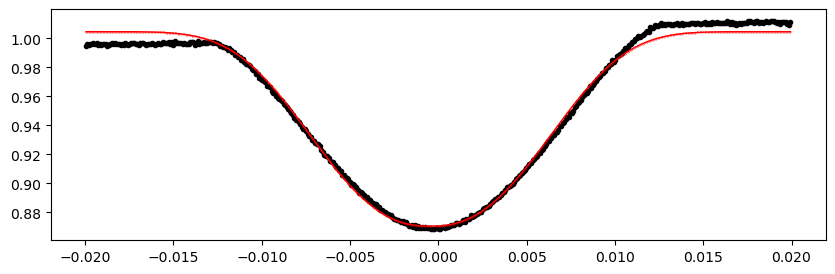

2748.458845 1.0022908037652092 -0.13443899934688142 -0.11998450484782985


100%|███████████████████████████████████████████████████████| 10000/10000 [00:40<00:00, 246.98it/s]


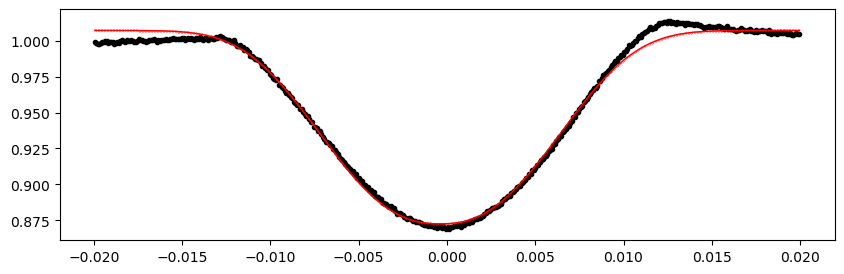

2764.715698 1.0022908037652092 -0.13443899934688142 -0.11998450484782985


100%|███████████████████████████████████████████████████████| 10000/10000 [00:40<00:00, 248.29it/s]


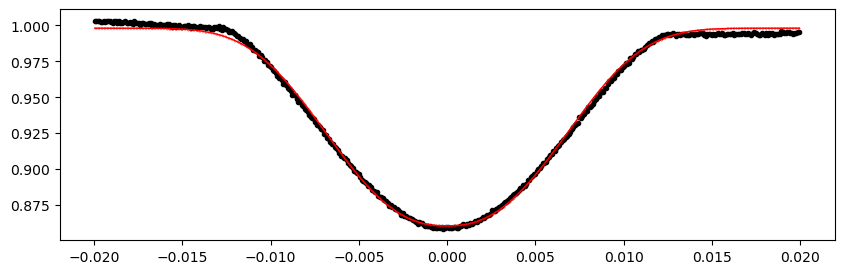

2829.7431100000003 1.0022908037652092 -0.13443899934688142 -0.11998450484782985


100%|███████████████████████████████████████████████████████| 10000/10000 [00:45<00:00, 221.59it/s]


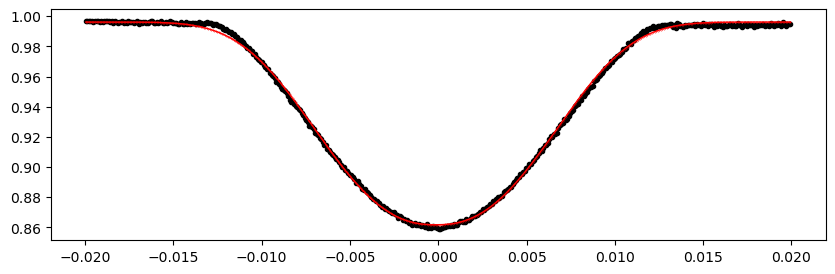

In [62]:
from importlib import reload
reload(etv_functions)

etv_functions.log.setLevel(logging.WARN)
print("Fitting individual primary eclipses...")
etv_functions.fit_each_eclipse(data_primary, n_transits, t0_primary, period, mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau, outfile_path)

print("Fitting individual secondary eclipses...")
etv_functions.fit_each_eclipse(data_secondary, n_transits, t0_secondary, period, mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s, outfile_path_s)

!$NOTIFY_CMD "Fitting individual eclipses done"

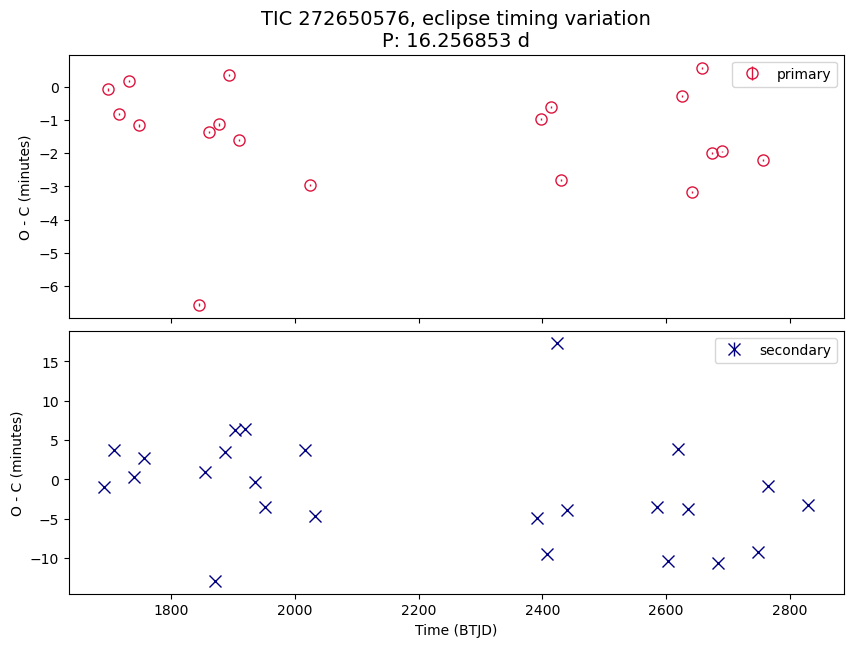

In [63]:
%matplotlib inline
# %matplotlib widget

#plot the extracted transit times to check for ETVs

fig, axs = plt.subplots(2, 1, figsize=(10, 7), sharex=True)

in_df_primary = pd.read_csv(outfile_path)
in_df_secondary = pd.read_csv(outfile_path_s)


in_df_primary['midpoint'] = in_df_primary['epoch'] + (in_df_primary['t0']*period)
in_df_primary['shift_mins'] = in_df_primary['t0']*period*24*60
in_df_primary['std_mins'] = in_df_primary['stdv_t0']*period*24*60

in_df_secondary['midpoint'] = in_df_secondary['epoch'] + (in_df_secondary['t0']*period)
in_df_secondary['shift_mins'] = in_df_secondary['t0']*period*24*60
in_df_secondary['std_mins'] = in_df_secondary['stdv_t0']*period*24*60

axs[0].errorbar(in_df_primary['epoch'], in_df_primary['shift_mins'], yerr = in_df_primary['std_mins'], 
             lw = 0, marker = 'o', elinewidth = 1, markersize = 8, color = 'None', ecolor='crimson', markeredgecolor = 'crimson', label="primary")
axs[1].errorbar(in_df_secondary['epoch'], in_df_secondary['shift_mins'], yerr = in_df_secondary['std_mins'], 
             lw = 0, marker = 'x', elinewidth = 1, markersize = 9, color = 'navy', zorder = -2, label="secondary" );

for ax in axs:
    ax.set_ylabel("O - C (minutes)")
    ax.legend();

axs[1].set_xlabel("Time (BTJD)")
axs[0].set_title(f"TIC {ticid}, eclipse timing variation\nP: {period} d", fontsize=14)

plt.subplots_adjust(hspace=0.05)
plt.show()

### Compare with the result from TCE1 Period and old `log_prior_fitting()`

Old `log_prior_fitting()` returns `-np.inf` when `not (-0.16 < alpha1 < 0)`, i.e., depth > 16%

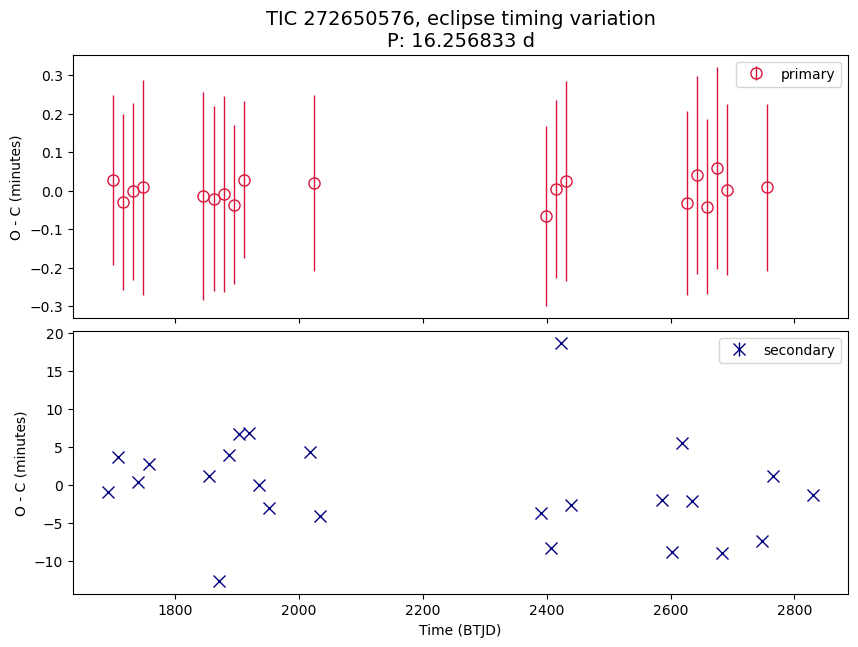

## make a periodogram 

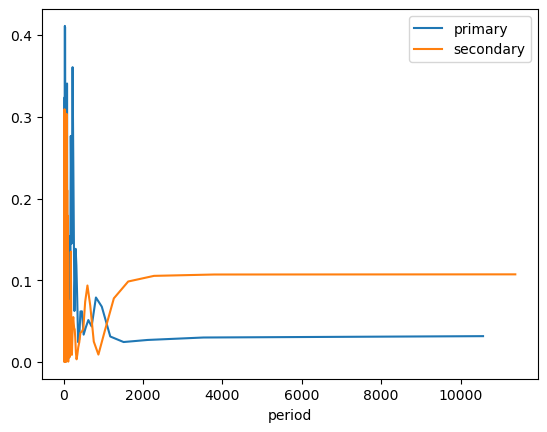

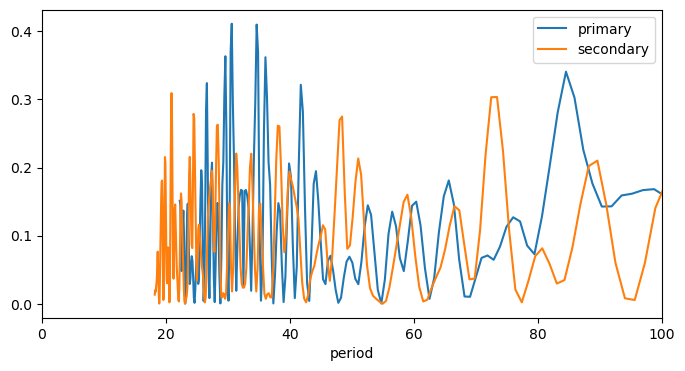

In [64]:
frequency, power = LombScargle(in_df_primary['epoch'], in_df_primary['shift_mins']).autopower()
frequency_s, power_s = LombScargle(in_df_secondary['epoch'], in_df_secondary['shift_mins']).autopower()

fig, ax = plt.subplots()

plt.plot(1/frequency, power, label = 'primary')    
plt.plot(1/frequency_s, power_s, label = 'secondary')    

plt.xlabel("period")

plt.legend()
plt.show()

if True:  # zoom-in
    fig, ax = plt.subplots(figsize=(8, 4))
    
    plt.plot(1/frequency, power, label = 'primary')    
    
    if t0_secondary is not None:
        frequency_s, power_s = LombScargle(in_df_secondary['epoch'], in_df_secondary['shift_mins']).autopower()
        plt.plot(1/frequency_s, power_s, label = 'secondary')    
    
    plt.xlabel("period")
    
    plt.legend()
    plt.xlim(0, 100)
    plt.show()

In [66]:
# FILL-IN the ETV results / comments
has_etv = "N?"
comments = "Scatter in O-C for both primary and secondary after depth restriction in log_prior_fitting() is relaxed. Data possibly too sparse."

# Eclipse depth from the model
depth_pct_p = round(-mean_alpha1 * 100, 2)
if t0_secondary is not None:
    depth_pct_s = round(-mean_alpha1_s * 100, 2)
else:
    depth_pct_s = None

summary = {
    "tic": ticid,
    "has_etv": has_etv,
    "comments": comments,
    "period": period,  # the period used in ETV analysis
    "depth_pct_p": depth_pct_p,
    "depth_pct_s": depth_pct_s,
    "epoch_p": t0_primary,
    "epoch_s": t0_secondary,
    "num_sectors": len(sr),
    "time_span": round(time[-1] - time[0], 2),
    "time_start": round(time[0], 2),
    "time_end": round(time[-1], 2),
}

summary = pd.DataFrame.from_dict(summary, orient="index")
with pd.option_context('display.max_colwidth', None, 'display.max_rows', 999, 'display.max_columns', 99):
    display(summary);

# Single line to be added to a CSV
print("")
print(summary.transpose().to_csv(
    index=False,
    header=True, 
))

,0
tic,272650576
has_etv,N?
comments,Scatter in O-C for both primary and secondary after depth restriction in log_prior_fitting() is relaxed. Data possibly too sparse.
period,16.256853
depth_pct_p,23.81
depth_pct_s,13.44
epoch_p,1699.2054
epoch_s,1691.7634
num_sectors,16
time_span,1169.78



tic,has_etv,comments,period,depth_pct_p,depth_pct_s,epoch_p,epoch_s,num_sectors,time_span,time_start,time_end
272650576,N?,Scatter in O-C for both primary and secondary after depth restriction in log_prior_fitting() is relaxed. Data possibly too sparse.,16.256853,23.81,13.44,1699.2054,1691.7634,16,1169.78,1683.35,2853.14

